# Lab 5 : Mixture Models+Model orden selection

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD5"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L5_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

### First part

Fill in the following class to implement a multivariate GMM:

$\mu = \frac{1}{n} \sum_{i=1}^n x_i$

In [19]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

class my_GMM():

    def __init__(self, k):
        '''
        Parameters:
        k: integer
            number of components

        Attributes:

        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k = k
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        self.alpha_history  = []
        self.mu_history     = []
        self.Sigma_history  = []

    def fit(self, X):
        """ Find the parameters
        that better fit the data

        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix

        Returns:
        -----
        self
        """

        max_iter = 100
        tol = 1e-4
        n, m = X.shape

        # initialize the parameters with kùeans
        kmeans = KMeans(n_clusters=self.k, n_init=10, random_state=42)
        kmeans.fit(X)
        self.mu_ = kmeans.cluster_centers_
        labels = kmeans.labels_
        self.alpha_ = np.array([np.sum(labels == i) for i in range(self.k)]) / n
        self.Sigma_ = np.array([np.cov(X[labels == i].T)  for i in range(self.k)])

        # Store history
        self.alpha_history.append(np.copy(self.alpha_))
        self.mu_history.append(np.copy(self.mu_))
        self.Sigma_history.append(np.copy(self.Sigma_))

        for _ in range(max_iter):
            prev_mu = np.copy(self.mu_)
            prev_Sigma = np.copy(self.Sigma_)
            prev_alpha = np.copy(self.alpha_)

            self.cond_prob_ = self.compute_proba(X)
            weight_clusters = np.sum(self.cond_prob_, axis=0)
            self.alpha_ = weight_clusters / n
            self.mu_ = (self.cond_prob_.T @ X) / weight_clusters[:, np.newaxis]

            for i in range(self.k):
                diff = X - self.mu_[i]
                weighted_diff = diff * self.cond_prob_[:, i][:, np.newaxis]
                self.Sigma_[i] = (weighted_diff.T @ diff) / weight_clusters[i]


            self.alpha_history.append(np.copy(self.alpha_))
            self.mu_history.append(np.copy(self.mu_))
            self.Sigma_history.append(np.copy(self.Sigma_))

            if np.allclose(self.mu_, prev_mu, atol=tol) and np.allclose(self.mu_, prev_mu) and np.allclose(np.array(self.Sigma_), np.array(prev_Sigma)):
                break

        self.labels_ = np.argmax(self.cond_prob_, axis=1)

        return self

    def predict(self, X):
        """ Predict labels for X

        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix

        Returns:
        -----
        label assigment
        """
        cond_prob = self.compute_proba(X)
        return np.argmax(cond_prob, axis=1)

    def compute_proba(self, X):
        """ Compute probability vector for X

        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix

        Returns:
        -----
        proba: (n, k) np.array
        """

        n = X.shape[0]
        likelihoods = np.zeros((n, self.k))

        for i in range(self.k):
            likelihoods[:, i] = multivariate_normal(mean=self.mu_[i], cov=self.Sigma_[i]).pdf(X)

        weighted_likelihoods = likelihoods * self.alpha_
        sum_likelihoods = np.sum(weighted_likelihoods, axis=1)[:, np.newaxis]

        cond_prob = weighted_likelihoods / sum_likelihoods

        return cond_prob

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`.

Plot data with colors representing predicted labels and shapes representing real labels.

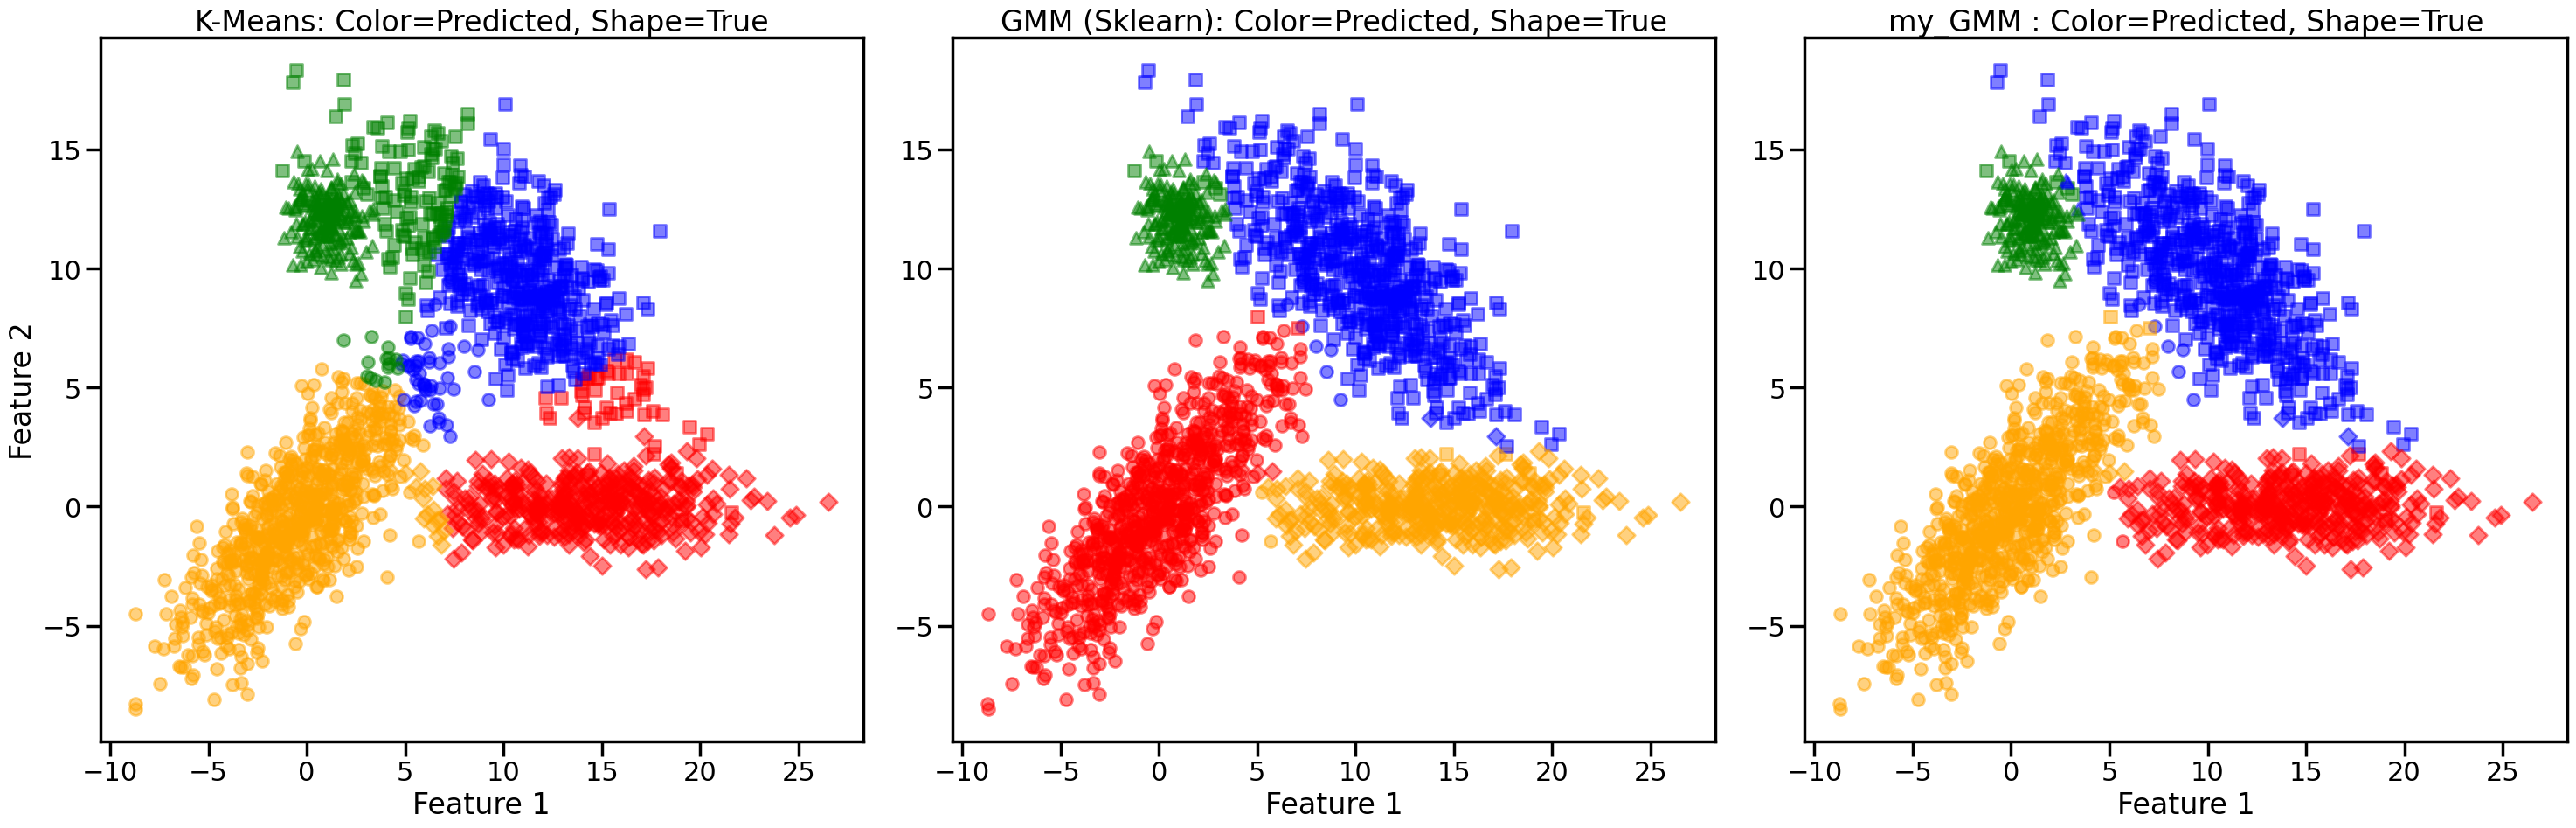

In [33]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture


k = 4 # Number of clusters
n_samples = 2000

weights = [0.4, 0.3, 0.1, 0.2]
means = np.array([
    [0,0], [10, 10], [1, 12], [14, 0]
])
covariances = [
    np.array([[10, 8], [8, 10]]),
    np.array([[12, -7], [-7, 8]]),
    np.array([[1, 0], [0, 1]]),
    np.array([[15, 0], [0, 1]])
]

X = []
real_labels_list = []
for i in range(k):
    n_cluster_samples = int(n_samples * weights[i])
    X_cluster = np.random.multivariate_normal(means[i], covariances[i], n_cluster_samples)
    X.append(X_cluster)
    real_labels_list.append(np.full(n_cluster_samples, fill_value=i))

X = np.vstack(X)
real_labels = np.hstack(real_labels_list)


kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

gmm_sklearn = GaussianMixture(n_components=k, random_state=42)
gmm_sklearn_labels = gmm_sklearn.fit_predict(X)

gmm = my_GMM(k=k)
gmm.fit(X)
gmm_labels = gmm.labels_


fig, ax = plt.subplots(1, 3, figsize=(30, 10))

shapes = ['o', 's', '^', 'D']
colors = ['red', 'orange', 'blue', 'green']

#  K-Means
for true_label in range(k):
    for pred_label in range(k):
        mask = (real_labels == true_label) & (kmeans_labels == pred_label)
        ax[0].scatter(X[mask, 0], X[mask, 1],
                      marker=shapes[true_label],
                      color=colors[pred_label],
                      s=100, alpha=0.5)
ax[0].set_title('K-Means: Color=Predicted, Shape=True')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')

# Sklearn's GMM
for true_label in range(k):
    for pred_label in range(k):
        mask = (real_labels == true_label) & (gmm_sklearn_labels == pred_label)
        ax[1].scatter(X[mask, 0], X[mask, 1],
                      marker=shapes[true_label],
                      color=colors[pred_label],
                      s=100, alpha=0.5)
ax[1].set_title('GMM (Sklearn): Color=Predicted, Shape=True')
ax[1].set_xlabel('Feature 1')

# my_GMM
for true_label in range(k):
    for pred_label in range(k):
        mask = (real_labels == true_label) & (gmm_labels == pred_label)
        ax[2].scatter(X[mask, 0], X[mask, 1],
                      marker=shapes[true_label],
                      color=colors[pred_label],
                      s=100, alpha=0.5)
ax[2].set_title('my_GMM : Color=Predicted, Shape=True')
ax[2].set_xlabel('Feature 1')

plt.tight_layout()
plt.show()

The plots clearly demonstrate the superiority of GMM for this dataset. The K-Means plot shows a poor fit, as its rigid, spherical assumptions cause it to incorrectly split the clusters, resulting in a mismatch between shapes (true labels) and colors (predicted labels). In contrast, both the GaussianMixture (Sklearn) and my_GMM plots show an alignment between shapes and colors. This confirms that both GMM implementations correctly modeled the covariance of each cluster.